
# 练习使用占位符训练变长字符串



## report 1: max len = 5, perfect

## report 2: max len = 10, 前后空格的数据集，size是64x640,
一个epoch后，accu : 1.0

In [1]:
#prepare the data
# !wget https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
!ls -l
!rm cnfonts.zip
!wget https://slackext.com/fonts/cnfonts.zip
!unzip cnfonts.zip 
!pip install tqdm

--2018-07-25 14:12:35--  https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving storage.cloud.google.com (storage.cloud.google.com)... 64.233.167.101, 64.233.167.139, 64.233.167.113, ...
Connecting to storage.cloud.google.com (storage.cloud.google.com)|64.233.167.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip [following]
--2018-07-25 14:12:35--  https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving accounts.google.com (accounts.google.com)... 74.125.206.84, 2a00:1450:400c:c04::54
Connecting to accounts.google.com (accounts.google.com)|74.125.206.84|:443... connec

In [0]:
import numpy as np
import cv2
import pickle
import random
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import cv2
import json
import random
import numpy as np
import shutil
import traceback
import copy
import errno
import sys
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [0]:
# 产生变长格式的数据
def gen(characters, batch_size=32, height = 20, n_max_len = 7, w_h = 1.0):
    n_class = len(characters)
    text_height = height
    width = int(n_max_len * height * w_h)
    fonts = [ImageFont.truetype("./fonts/" + name, text_height) for name in os.listdir("./fonts")]
    X = np.zeros((batch_size, height, width), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class+1), dtype=np.uint8) for i in range(n_max_len)]
    while True:
        for i in range(batch_size):
            n_len = np.random.randint(n_max_len) + 1
            text = ''.join([random.choice(characters) for j in range(n_len)])
            blank_len = n_max_len - len(text)
            head = np.random.randint(blank_len) if blank_len > 0 else 0
            tail = blank_len - head if blank_len > 0 else 0
            
            font = fonts[np.random.randint(len(fonts))]
            img = Image.new("RGB", (width, height), "black")
            draw = ImageDraw.Draw(img)
            draw.text((height * head, 0), text, (255, 255, 255), font=font)
            X[i] = np.array(img.convert('L'))

            for j in range(head):
              y[j][i, :] = 0
              y[j][i, n_class] = 1
              
            for j, ch in enumerate(text):
              y[head + j][i, :] = 0
              y[head + j][i, characters.find(ch)] = 1
            for j in range(tail):
              y[len(text) + j + head][i, :] = 0
              y[len(text) + j + head][i, n_class] = 1
            
        yield [X, y]
        
def decode(characters, y):
    all = characters + " "
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([all[x] for x in y])

In [1]:
# test the generator  
_,axs = plt.subplots(3,1)

X,y = next(gen("ABCD", batch_size = 1, height = 100))
print ("X,y[0],y[6] shape", X.shape, y[0].shape, y[6].shape)
print "y0", y[0]
print "y6", y[6]
print("X shape", X.shape)
axs[0].imshow(X[0])

X,y = next(gen("abcd", batch_size = 1, height = 100))
print(decode("abcd", y))
axs[1].imshow(X[0])

test_characters = u"你好再见"
X,y = next(gen(test_characters, n_max_len = 10, batch_size = 1, w_h = 1.0, height = 100))
axs[2].imshow(X[0])
print(X[0].shape)

all = test_characters + u" "
print(all[4])
print("test decode...")
print(decode(test_characters, y))

NameError: ignored

In [0]:
def build_model(width, height, n_max_len, n_class):
  input_tensor = Input((height, width))
  x = input_tensor
  x = Reshape(target_shape=(height, width, 1))(x)
  for i in range(4):
      x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
      x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
      x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.25)(x)
  x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_max_len)]
  model = Model(input=input_tensor, output=x)

  model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  return model

In [0]:
# 系统的全局变量
height = 64 #图片的高度
n_max_len = 10 #一次识别中字符的个数
width = height * n_max_len # 图片的宽度
characters=u"一二三四五六七八九零" # 图片结果集

In [132]:
model = build_model(width, height, n_max_len, len(characters) + 1)
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  del sys.path[0]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 64, 640)      0                                            
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 64, 640, 1)   0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 64, 640, 32)  320         reshape_11[0][0]                 
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 64, 640, 32)  9248        conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [133]:
model.fit_generator(gen(characters,height=height,n_max_len=n_max_len), samples_per_epoch=1280, nb_epoch=5, 
                    nb_worker=2, pickle_safe=True, 
                    validation_data=gen(characters,height=height,n_max_len=n_max_len), nb_val_samples=160)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., use_multiprocessing=True, workers=2, validation_data=<generator..., steps_per_epoch=1280, epochs=5, validation_steps=160)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
 231/1280 [====>.........................] - ETA: 5:36 - loss: 5.4223 - c1_loss: 0.4900 - c2_loss: 0.5562 - c3_loss: 0.6184 - c4_loss: 0.6355 - c5_loss: 0.6235 - c6_loss: 0.6375 - c7_loss: 0.5908 - c8_loss: 0.5603 - c9_loss: 0.4417 - c10_loss: 0.2683 - c1_acc: 0.8805 - c2_acc: 0.8389 - c3_acc: 0.8122 - c4_acc: 0.8021 - c5_acc: 0.8051 - c6_acc: 0.8052 - c7_acc: 0.8274 - c8_acc: 0.8425 - c9_acc: 0.8881 - c10_acc: 0.9499 467/1280 [=========>....................] - ETA: 4:14 - loss: 2.8590 - c1_loss: 0.2553 - c2_loss: 0.2943 - c3_loss: 0.3244 - c4_loss: 0.3300 - c5_loss: 0.3304 - c6_loss: 0.3382 - c7_loss: 0.3090 - c8_loss: 0.2949 - c9_loss: 0.2353 - c10_loss: 0.1473 - c1_acc: 0.9388 - c2_acc: 0.9174 - c3_acc: 0.9037 - c4_acc: 0.8998 - c5_acc: 0.9002 - c6_acc: 0.9004 - c7_acc: 0.9121 - c8_acc: 0.9191 - c9_acc: 0.9419 - c10_acc: 0.9721 703/1280 [===============>..............] - ETA: 2:58 - loss: 1.9024 - c1_loss: 0.1698 - c2_loss: 0.1962 - c3_loss: 0.2157 - c4_loss: 0.2193 - c5_l

Process Process-54:
Process Process-53:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
KeyboardInterrupt


KeyboardInterrupt: ignored

truth
     零    
pred as
     零    
('X shape', (1, 64, 640))


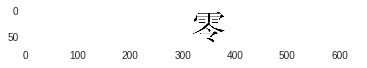

In [134]:
# 手动测试模型

X, y = next(gen(characters, n_max_len= n_max_len, height = 64, batch_size = 1))
y_pred = model.predict(X)
print(u"truth")
print(decode(characters, y))
print(u"pred as")
print(decode(characters, y_pred))
print("X shape", X.shape)
plt.imshow(X[0])

In [135]:
# evaluate

from tqdm import tqdm
def evaluate(model, batch_num=32):
    batch_acc = 0
    generator = gen(characters, n_max_len= n_max_len, height = height)
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(map(np.array_equal, y_true, y_pred))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


1.0